In [3]:
%%bash
wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
unzip wikitext-2-v1.zip

--2023-01-16 22:06:05--  https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.90.22, 52.216.25.134, 52.217.104.22, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.90.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4475746 (4.3M) [application/zip]
Saving to: ‘wikitext-2-v1.zip’

     0K .......... .......... .......... .......... ..........  1%  386K 11s
    50K .......... .......... .......... .......... ..........  2%  390K 11s
   100K .......... .......... .......... .......... ..........  3%  396K 11s
   150K .......... .......... .......... .......... ..........  4%  189K 14s
   200K .......... .......... .......... .......... ..........  5%  107M 11s
   250K .......... .......... .......... .......... ..........  6%  115M 9s
   300K .......... .......... .......... .......... ..........  8%  117M 7s
   350K .......... .......... .......... .......... ..........  9%

Archive:  wikitext-2-v1.zip
   creating: wikitext-2/
  inflating: wikitext-2/wiki.test.tokens  
  inflating: wikitext-2/wiki.valid.tokens  
  inflating: wikitext-2/wiki.train.tokens  


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 14})

In [2]:
TRAIN_TOKENS = 'wikitext-2/wiki.train.tokens'
VALID_TOKENS = 'wikitext-2/wiki.valid.tokens'

SKIPGRAM_N_WORDS = 4
MIN_WORD_FREQUENCY = 20
MAX_SEQUENCE_LENGTH = 256

EMBED_DIM = 256
EMBED_MAX_NORM = 1
BATCH_SIZE = 16
NUM_EPOCHS = 20

In [3]:
tokenizer = get_tokenizer('basic_english', language='en')

def load_and_preprocess_dataset(path):
    with open(path, 'r') as file:
        lines = file.readlines()
    
    data = list(filter(
        lambda sent: len(sent) > SKIPGRAM_N_WORDS * 2,
        map(tokenizer, lines)
    ))

    return data

In [4]:
train_data = load_and_preprocess_dataset(TRAIN_TOKENS)
valid_data = load_and_preprocess_dataset(VALID_TOKENS)

total_train_tokens = sum(len(sent) for sent in train_data)
total_valid_tokens = sum(len(sent) for sent in valid_data)

print(f'Num sentences: train - {len(train_data)}, valid - {len(valid_data)})')
print(f'Total tokens: train - {total_train_tokens}, valid - {total_valid_tokens})')
print(f'Average tokens in sentence: {total_train_tokens / len(train_data):.2f}')

Num sentences: train - 17715, valid - 1892)
Total tokens: train - 2014338, valid - 211057)
Average tokens in sentence: 113.71


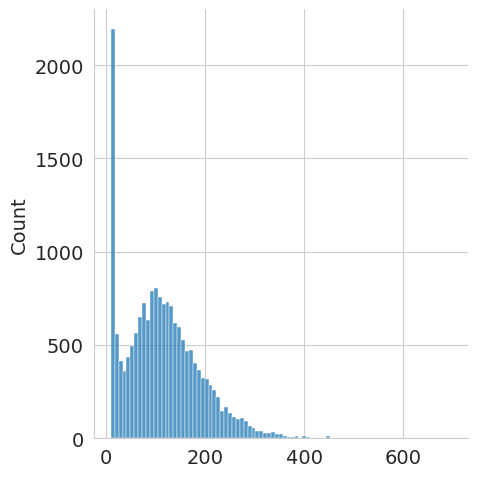

In [5]:
_ = sns.displot([len(sent) for sent in train_data])

In [6]:
vocab = build_vocab_from_iterator(train_data, specials=["<unk>"], min_freq=MIN_WORD_FREQUENCY)
vocab.set_default_index(vocab["<unk>"])

VOCAB_SIZE = len(vocab)
print(f'Vocab size: {VOCAB_SIZE}')

Vocab size: 8076


In [7]:
train_data[50]

['during',
 'the',
 'month',
 'of',
 'august',
 ',',
 '1862',
 ',',
 'the',
 'following',
 'work',
 'was',
 'performed',
 '<unk>',
 'one',
 'pair',
 'of',
 'musket',
 'bullet',
 'moulds',
 '10',
 '@',
 ',',
 '@',
 '000',
 'buck',
 '&',
 'ball',
 'shot',
 'cartridges',
 'repaired',
 '750',
 '<unk>',
 ',',
 'shotguns',
 ',',
 'and',
 'rifles',
 'received',
 'and',
 'repaired',
 'ordnance',
 'stores',
 'and',
 '<unk>',
 'performed',
 'guard',
 ',',
 'office',
 ',',
 'and',
 'police',
 'duties',
 'inspected',
 '<unk>',
 'at',
 'camden',
 'and',
 'arkadelphia',
 '.']

In [8]:
vocab(train_data[50])

[56,
 1,
 689,
 4,
 181,
 2,
 5892,
 2,
 1,
 133,
 138,
 9,
 469,
 0,
 40,
 1457,
 4,
 0,
 6904,
 0,
 160,
 19,
 2,
 19,
 98,
 0,
 379,
 749,
 788,
 0,
 6648,
 7096,
 0,
 2,
 0,
 2,
 5,
 2668,
 200,
 5,
 6648,
 6450,
 3980,
 5,
 0,
 469,
 2055,
 2,
 697,
 2,
 5,
 714,
 2964,
 0,
 0,
 25,
 0,
 5,
 0,
 3]

In [9]:
def collate_fn(batch):
    """
    Collate_fn for Skip-Gram model to be used with Dataloader.
    `batch` is expected to be list of text paragrahs.

    Context is represented as N=SKIPGRAM_N_WORDS past words 
    and N=SKIPGRAM_N_WORDS future words.

    Long paragraphs will be truncated to contain
    no more that MAX_SEQUENCE_LENGTH tokens.

    Each element in `batch_input` is a middle word.
    Each element in `batch_output` is a context word.
    """
    batch_input, batch_output = [], []
    for text in batch:
        text_tokens_ids = vocab(text)

        if MAX_SEQUENCE_LENGTH:
            text_tokens_ids = text_tokens_ids[:MAX_SEQUENCE_LENGTH]

        for idx in range(len(text_tokens_ids) - SKIPGRAM_N_WORDS * 2):
            token_id_sequence = text_tokens_ids[idx : (idx + SKIPGRAM_N_WORDS * 2 + 1)]
            input_ = token_id_sequence.pop(SKIPGRAM_N_WORDS)
            outputs = token_id_sequence

            batch_input += [input_] * len(outputs)
            batch_output += outputs

    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    return batch_input, batch_output

In [10]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=4,
                          pin_memory=True, collate_fn=collate_fn, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, num_workers=4,
                          pin_memory=True, collate_fn=collate_fn)

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [13]:
from IPython.display import clear_output
from tqdm.notebook import tqdm


def plot_losses(train_losses, valid_losses):
    clear_output()
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='train', color='deepskyblue', linewidth=2)
    plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='valid', color='springgreen', linewidth=2)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [14]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, num_batches = 0.0, 1
    model.train()
    for inputs, outputs in tqdm(train_loader, desc=tqdm_desc):
        inputs = inputs.to(device)
        outputs = outputs.to(device)

        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits, outputs)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        num_batches += 1

    train_loss /= num_batches
    return train_loss


@torch.no_grad()
def validation_epoch(model, criterion, valid_loader, tqdm_desc):
    valid_loss, num_batches = 0.0, 0
    model.eval()
    for inputs, outputs in tqdm(valid_loader, desc=tqdm_desc):
        inputs = inputs.to(device)
        outputs = outputs.to(device)

        logits = model(inputs)
        loss = criterion(logits, outputs)

        valid_loss += loss.item()
        num_batches += 1

    valid_loss /= num_batches
    return valid_loss


def train(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs):
    train_losses, valid_losses = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        valid_loss = validation_epoch(
            model, criterion, valid_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        valid_losses += [valid_loss]
        plot_losses(train_losses, valid_losses)

In [15]:
class Word2VecModel(nn.Module):
    def __init__(self, embed_dim, embed_max_norm, vocab_size):
        super().__init__()
        self.embeds = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim,
                                   max_norm=embed_max_norm)
        self.decoder = nn.Linear(embed_dim, vocab_size)
        
    def forward(self, tokens):
        embeds = self.embeds(tokens)
        logits = self.decoder(embeds)
        return logits

In [16]:
model = Word2VecModel(embed_dim=EMBED_DIM, embed_max_norm=EMBED_MAX_NORM,
                      vocab_size=VOCAB_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, NUM_EPOCHS)
criterion = nn.CrossEntropyLoss()

In [18]:
from tqdm.notebook import tqdm

In [22]:
train(model, optimizer, scheduler, criterion, train_loader, valid_loader, NUM_EPOCHS)

Training 1/20:   0%|          | 0/1108 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 460.00 MiB (GPU 0; 11.77 GiB total capacity; 2.01 GiB already allocated; 406.19 MiB free; 3.41 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF